### Import python packages
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch_legendre import LegendreLayer

---
### Data set
---

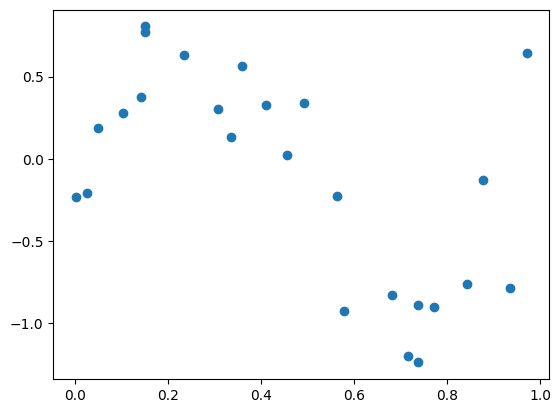

In [2]:
data = np.array([
    0.001399613, -0.23436656,
    0.971629779,  0.64689524,
    0.579119475, -0.92635765,
    0.335693937,  0.13000706,
    0.736736086, -0.89294863,
    0.492572335,  0.33854780,
    0.737133774, -1.24171910,
    0.563693769, -0.22523318,
    0.877603280, -0.12962722,
    0.141426545,  0.37632006,
    0.307203910,  0.30299077,
    0.024509308, -0.21162739,
    0.843665029, -0.76468719,
    0.771206067, -0.90455412,
    0.149670258,  0.77097952,
    0.359605608,  0.56466366,
    0.049612895,  0.18897607,
    0.409898906,  0.32531750,
    0.935457898, -0.78703491,
    0.149476207,  0.80585375,
    0.234315216,  0.62944986,
    0.455297119,  0.02353327,
    0.102696671,  0.27621694,
    0.715372314, -1.20379729,
    0.681745393, -0.83059624 ]).reshape(25,2)

X = torch.tensor(data[:, 0:1], dtype=torch.float32)
y = torch.tensor(data[:, 1:2], dtype=torch.float32)

plt.scatter(X[:,0], y)
plt.show()

---
### Train the Legendre polynomial
---

In [3]:
degree = 1000
model = LegendreLayer(in_features=1, out_features=1, degree=degree)

# Loss & optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)

# Training loop
epochs = 8000
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred, y) #+ 0.001*torch.sum(model.weight**2)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}, Loss = {loss.item():.6f}")

Epoch 500, Loss = 0.105089
Epoch 1000, Loss = 0.022516
Epoch 1500, Loss = 0.006607
Epoch 2000, Loss = 0.003814
Epoch 2500, Loss = 0.003104
Epoch 3000, Loss = 0.002760
Epoch 3500, Loss = 0.002524
Epoch 4000, Loss = 0.002349
Epoch 4500, Loss = 0.002213
Epoch 5000, Loss = 0.002107
Epoch 5500, Loss = 0.002022
Epoch 6000, Loss = 0.001956
Epoch 6500, Loss = 0.001903
Epoch 7000, Loss = 0.001861
Epoch 7500, Loss = 0.001829
Epoch 8000, Loss = 0.001805


---
### Results
---

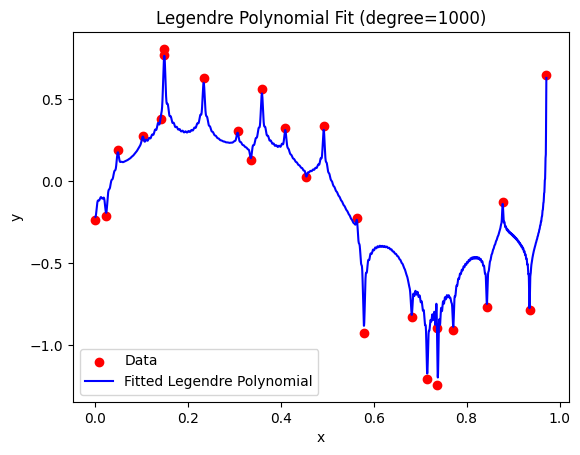

In [4]:
x_plot = torch.linspace(X.min().item(), X.max().item(), 5000).unsqueeze(1)
y_plot = model(x_plot).detach().numpy()

plt.scatter(X.numpy(), y.numpy(), color='red', label='Data')
plt.plot(x_plot.numpy(), y_plot, color='blue', label='Fitted Legendre Polynomial')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title(f"Legendre Polynomial Fit (degree={degree})")
plt.show()

---
## Analytical Solution
---

In [5]:
class LegendrePolynomialRegressor:
    def __init__(self, p=3, alpha=0.0):
        self.p     = p
        self.theta = None
        self.alpha = alpha

    def fit(self, X, y):
        F = self.compute_features(X)
        self.theta = np.linalg.pinv(F.transpose()@F + self.alpha*np.identity(F.shape[1]))@F.transpose()@y

    def compute_features(self, X):
        x = X if len(X.shape) == 1 else X[:,0]
        F = np.array([]).reshape(x.shape[0], 0)
        # Generate polynomial features
        for deg in range(self.p):
            l = np.polynomial.legendre.Legendre([0]*deg + [1])
            F = np.insert(F, deg, l(x), axis=1)
        return F

    def predict(self, X):
        F = self.compute_features(X)
        return F@self.theta

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def get_params(self, deep=True):
        return {"p" : self.p, "alpha" : self.alpha}

In [6]:
clf = LegendrePolynomialRegressor(p=1000)
clf.fit(X.numpy(), y.numpy())

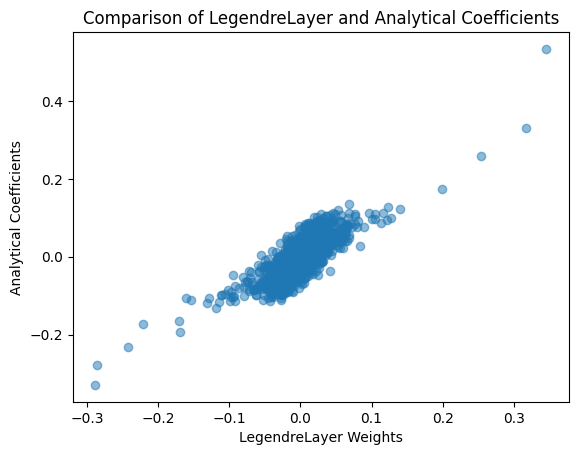

In [7]:
plt.scatter(model.linear.weight.data.numpy(), clf.theta[:,0], alpha=0.5)
plt.xlabel('LegendreLayer Weights')
plt.ylabel('Analytical Coefficients')
plt.title('Comparison of LegendreLayer and Analytical Coefficients')
plt.show()

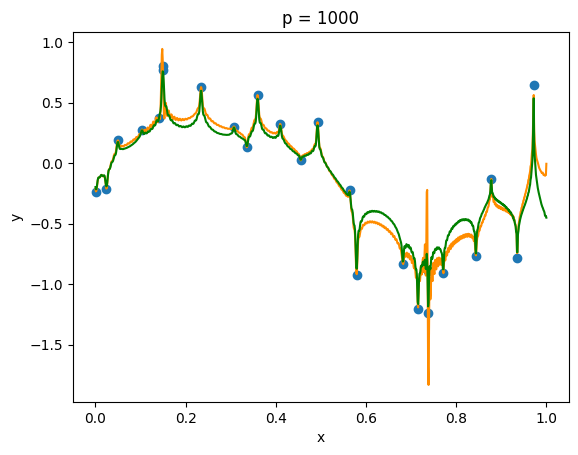

In [9]:
X_test = np.linspace(0, 1, 1000)
plt.plot(X_test, clf.predict(X_test), color="darkorange")
plt.plot(X_test, model(torch.tensor(X_test.reshape(-1,1), dtype=torch.float)).detach().numpy(), color="green")
plt.scatter(X, y)
plt.title("p = 1000")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

---
## Train a stacked Legendre polynomial
---

In [10]:
model = model = nn.Sequential(
    LegendreLayer(in_features=1, out_features = 10, degree=500),
    LegendreLayer(in_features=10, out_features = 1, degree=10))

# Loss & optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)

# Training loop
epochs = 8000
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}, Loss = {loss.item():.6f}")

Epoch 500, Loss = 0.004490
Epoch 1000, Loss = 0.002554
Epoch 1500, Loss = 0.002119
Epoch 2000, Loss = 0.001864
Epoch 2500, Loss = 0.001689
Epoch 3000, Loss = 0.001564
Epoch 3500, Loss = 0.001475
Epoch 4000, Loss = 0.001412
Epoch 4500, Loss = 0.001368
Epoch 5000, Loss = 0.001337
Epoch 5500, Loss = 0.001298
Epoch 6000, Loss = 0.001279
Epoch 6500, Loss = 0.001264
Epoch 7000, Loss = 0.001248
Epoch 7500, Loss = 0.001232
Epoch 8000, Loss = 0.001220


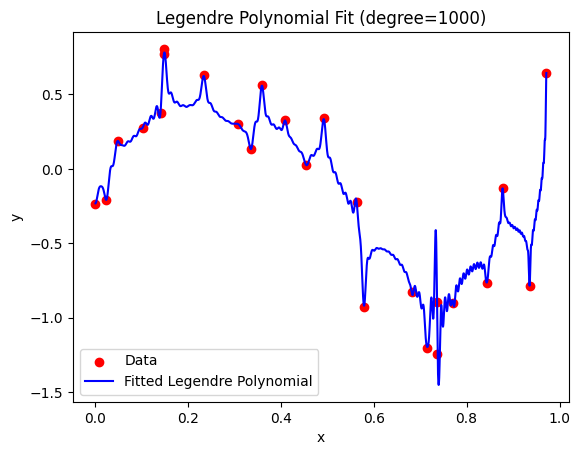

In [11]:
x_plot = torch.linspace(X.min().item(), X.max().item(), 5000).unsqueeze(1)
y_plot = model(x_plot).detach().numpy()

plt.scatter(X.numpy(), y.numpy(), color='red', label='Data')
plt.plot(x_plot.numpy(), y_plot, color='blue', label='Fitted Legendre Polynomial')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title(f"Legendre Polynomial Fit (degree={degree})")
plt.show()